In [1]:
import subprocess
import shlex
import re
import json

import numpy as np
import multiprocessing as mp

from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [2]:
import scipy.special as sp

def s_migration(A_eff_local, deme_local, A_eff_meta, deme_meta, my_local, nu_meta):
    J = A_eff_local * deme_local
    J_m = A_eff_meta * deme_meta
    
    theta = (J_m - 1) * nu_meta / (1.0 - nu_meta)
    lamda = (J - 1) * my_local / (1.0 - my_local)
    
    return theta * (sp.digamma(theta + lamda * (sp.digamma(lamda + J) - sp.digamma(lamda))) - sp.digamma(theta))

def s_migration_limit(A_eff_local, deme_local, A_eff_meta, deme_meta, my_local, nu_meta):
    J = A_eff_local * deme_local
    J_m = A_eff_meta * deme_meta
    
    theta = (J_m - 1) * nu_meta / (1.0 - nu_meta)
    lamda = (J - 1) * my_local / (1.0 - my_local)
    
    return theta * np.log(1.0 - (lamda / theta) * np.log(my_local))

def s_always_migration(A_eff_local, deme_local, A_eff_meta, deme_meta, nu_meta):
    J = A_eff_local * deme_local
    J_m = A_eff_meta * deme_meta
    
    theta = (J_m - 1) * nu_meta / (1.0 - nu_meta)
    
    return theta * np.log(1 + (J - 1) / theta)

In [3]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")
MIGRATION_PATTERN = re.compile(r"There were \d+ migrations to (\d+) ancestors on a finite metacommunity of size \d+ during the simulation\.")

In [4]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [5]:
def simulate_static_spatially_implicit_scenario(speciation=0.1, seed=42, local=(10, 10, 10), meta=(10, 10, 10), migration=0.1):
    config = "".join(f"""
    (
        speciation: {migration},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: NonSpatial(
            area: ({local[0]}, {local[1]}),
            deme: {local[2]},
            spatial: false,
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_metacommunity.so",
                reporters: [
                    Metacommunity(
                        metacommunity: Finite({meta[0]*meta[1]*meta[2]}),
                        seed: {seed},
                    )
                ]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = MIGRATION_PATTERN.search(result.stdout)
    ancestors = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    local_time = float(match.group(1))
    local_steps = int(match.group(2))
    
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: {ancestors / (meta[0]*meta[1]*meta[2])},
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: NonSpatial(
            area: ({meta[0]}, {meta[1]}),
            deme: {meta[2]},
            spatial: false,
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    meta_time = float(match.group(1))
    meta_steps = int(match.group(2))
        
    return biodiversity, (local_time + meta_time), (local_steps + meta_steps)

In [6]:
def simulate_dynamic_spatially_implicit_scenario(speciation=0.1, seed=42, local=(10, 10, 10), meta=(10, 10, 10), migration=0.1):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: SpatiallyImplicit(
            local_area: ({local[0]}, {local[1]}),
            local_deme: {local[2]},
            meta_area: ({meta[0]}, {meta[1]}),
            meta_deme: {meta[2]},
            migration: {migration}
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [7]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def report_error(err):
            print(err)
        
        def update_progress(result):
            results.append(result)

            progress.update()

        with mp.Pool(mp.cpu_count()) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress, report_error)

            pool.close()
            pool.join()
    
    return results

In [8]:
def simulate_meta_migration_super_batch(speciation=0.001, local=(10, 10, 10), metas=[(10, 10, 10)], migrations=[0.1], size=10):
    Metas = []
    Migrations = []
    Static = []
    Dynamic = []

    for migration in migrations:
        for meta in metas:
            seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=size)

            Metas.append(meta[0]*meta[1]*meta[2])
            Migrations.append(migration)

            results = batch_simulation_many_seeds(simulate_static_spatially_implicit_scenario, seeds, kwargs={
                "local":local, "meta":meta, "migration": migration, "speciation": speciation
            }, silent=True)
            biodiversities, times, steps = tuple(zip(*results))

            Static.append(np.mean(biodiversities))

            results = batch_simulation_many_seeds(simulate_dynamic_spatially_implicit_scenario, seeds, kwargs={
                "local":local, "meta":meta, "migration": migration, "speciation": speciation
            }, silent=True)
            biodiversities, times, steps = tuple(zip(*results))

            Dynamic.append(np.mean(biodiversities))
    
    return Metas, Migrations, Static, Dynamic

# II. Verify correct convergence of the SpatiallyImplicit scenario
## II.1. Compute the biodiversity for a mesh of metacommunity sizes x migration probabilities

In [9]:
Metas, Migrations, Static, Dynamic = simulate_meta_migration_super_batch(speciation=0.001, local=(10, 10, 10), metas=[
    (1, 1, 1), (2, 1, 1), (3, 1, 1), (6, 1, 1),
    (10, 1, 1), (10, 2, 1), (10, 3, 1), (10, 6, 1),
    (10, 10, 1), (10, 10, 2), (10, 10, 3), (10, 10, 6),
    (10, 10, 10), (18, 10, 10), (31, 10, 10), (56, 10, 10),
    (100, 10, 10), (100, 18, 10), (100, 31, 10), (100, 56, 10),
    (100, 100, 10), (100, 100, 18), (100, 100, 31), (100, 100, 56),
    (100, 100, 100)
], migrations=[0.01, 0.018, 0.031, 0.056, 0.1, 0.18, 0.31, 0.56, 0.99], size=100)

In [10]:
Expected = [
    s_migration(10*10, 10, meta, 1, migration, 0.001) if meta > 1 else 1
    for meta, migration in zip(Metas, Migrations)
]

## II.2 Plot the expected biodiversity surface

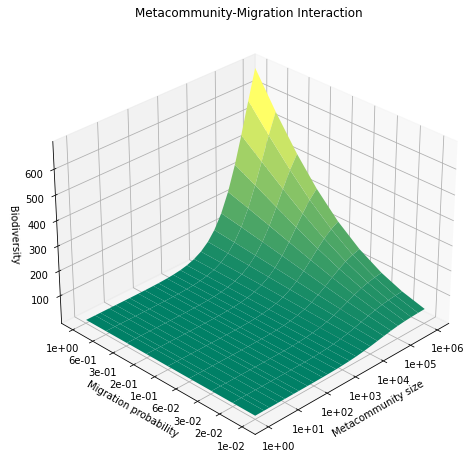

In [11]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})

ax.set_title("Metacommunity-Migration Interaction")

def log_tick_formatter(val, pos=None):
    return "{:.0e}".format(10**val)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

ax.set_xlabel("Metacommunity size")
ax.set_ylabel("Migration probability")
ax.set_zlabel("Biodiversity")

ax.plot_surface(
    np.log10(np.array(Metas).reshape((9, 25))),
    np.log10(np.array(Migrations).reshape((9, 25))),
    np.array(Expected).reshape((9, 25)),
    antialiased=True, cmap='summer'
)

ax.view_init(30, 225)

plt.show()

## II.3 Plot the effect of metacommunity size on biodiversity

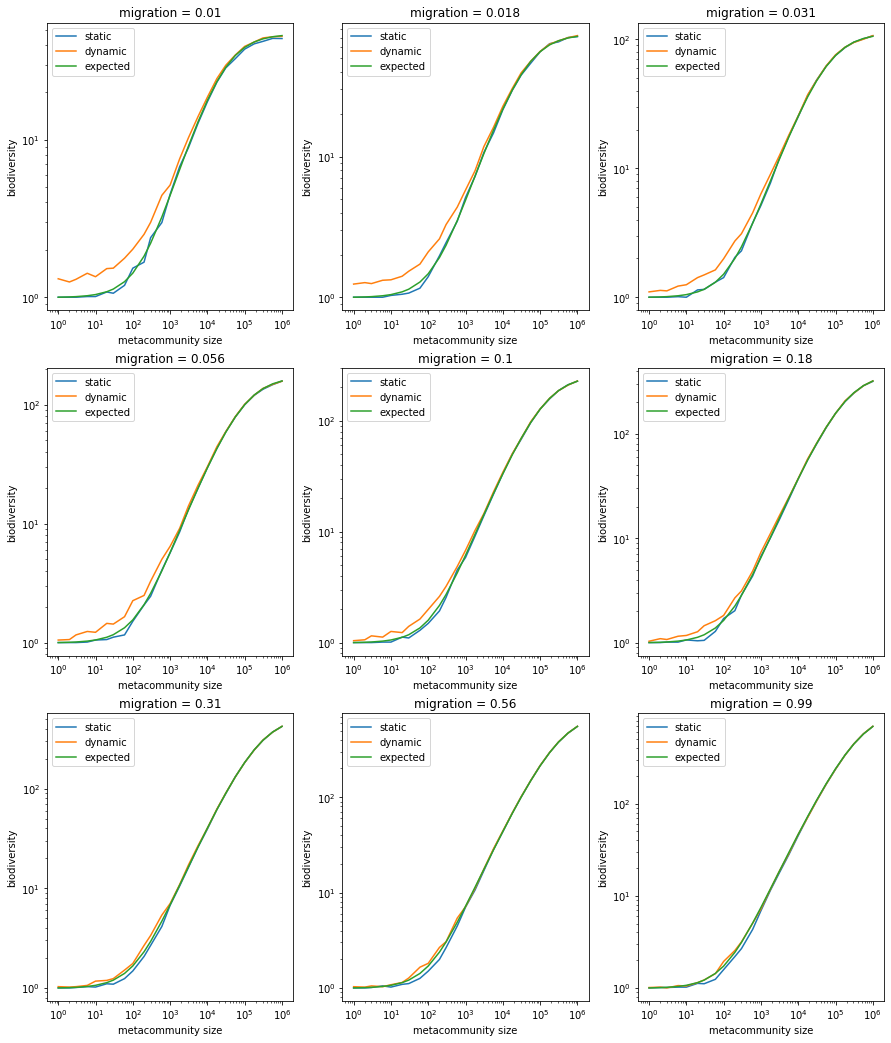

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 18))

for i in range(9):
    ax = axes[i // 3][i % 3]
    
    si = 25 * i
    ei = si + 25
    
    ax.set_title(f"migration = {Migrations[si]}")
    ax.set_xlabel('metacommunity size')
    ax.set_ylabel('biodiversity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(Metas[si:ei], Static[si:ei], label='static')
    ax.plot(Metas[si:ei], Dynamic[si:ei], label='dynamic')
    ax.plot(Metas[si:ei], Expected[si:ei], label='expected')
    ax.legend()

plt.show()

## II.4 Plot the effect of migration rates on biodiversity

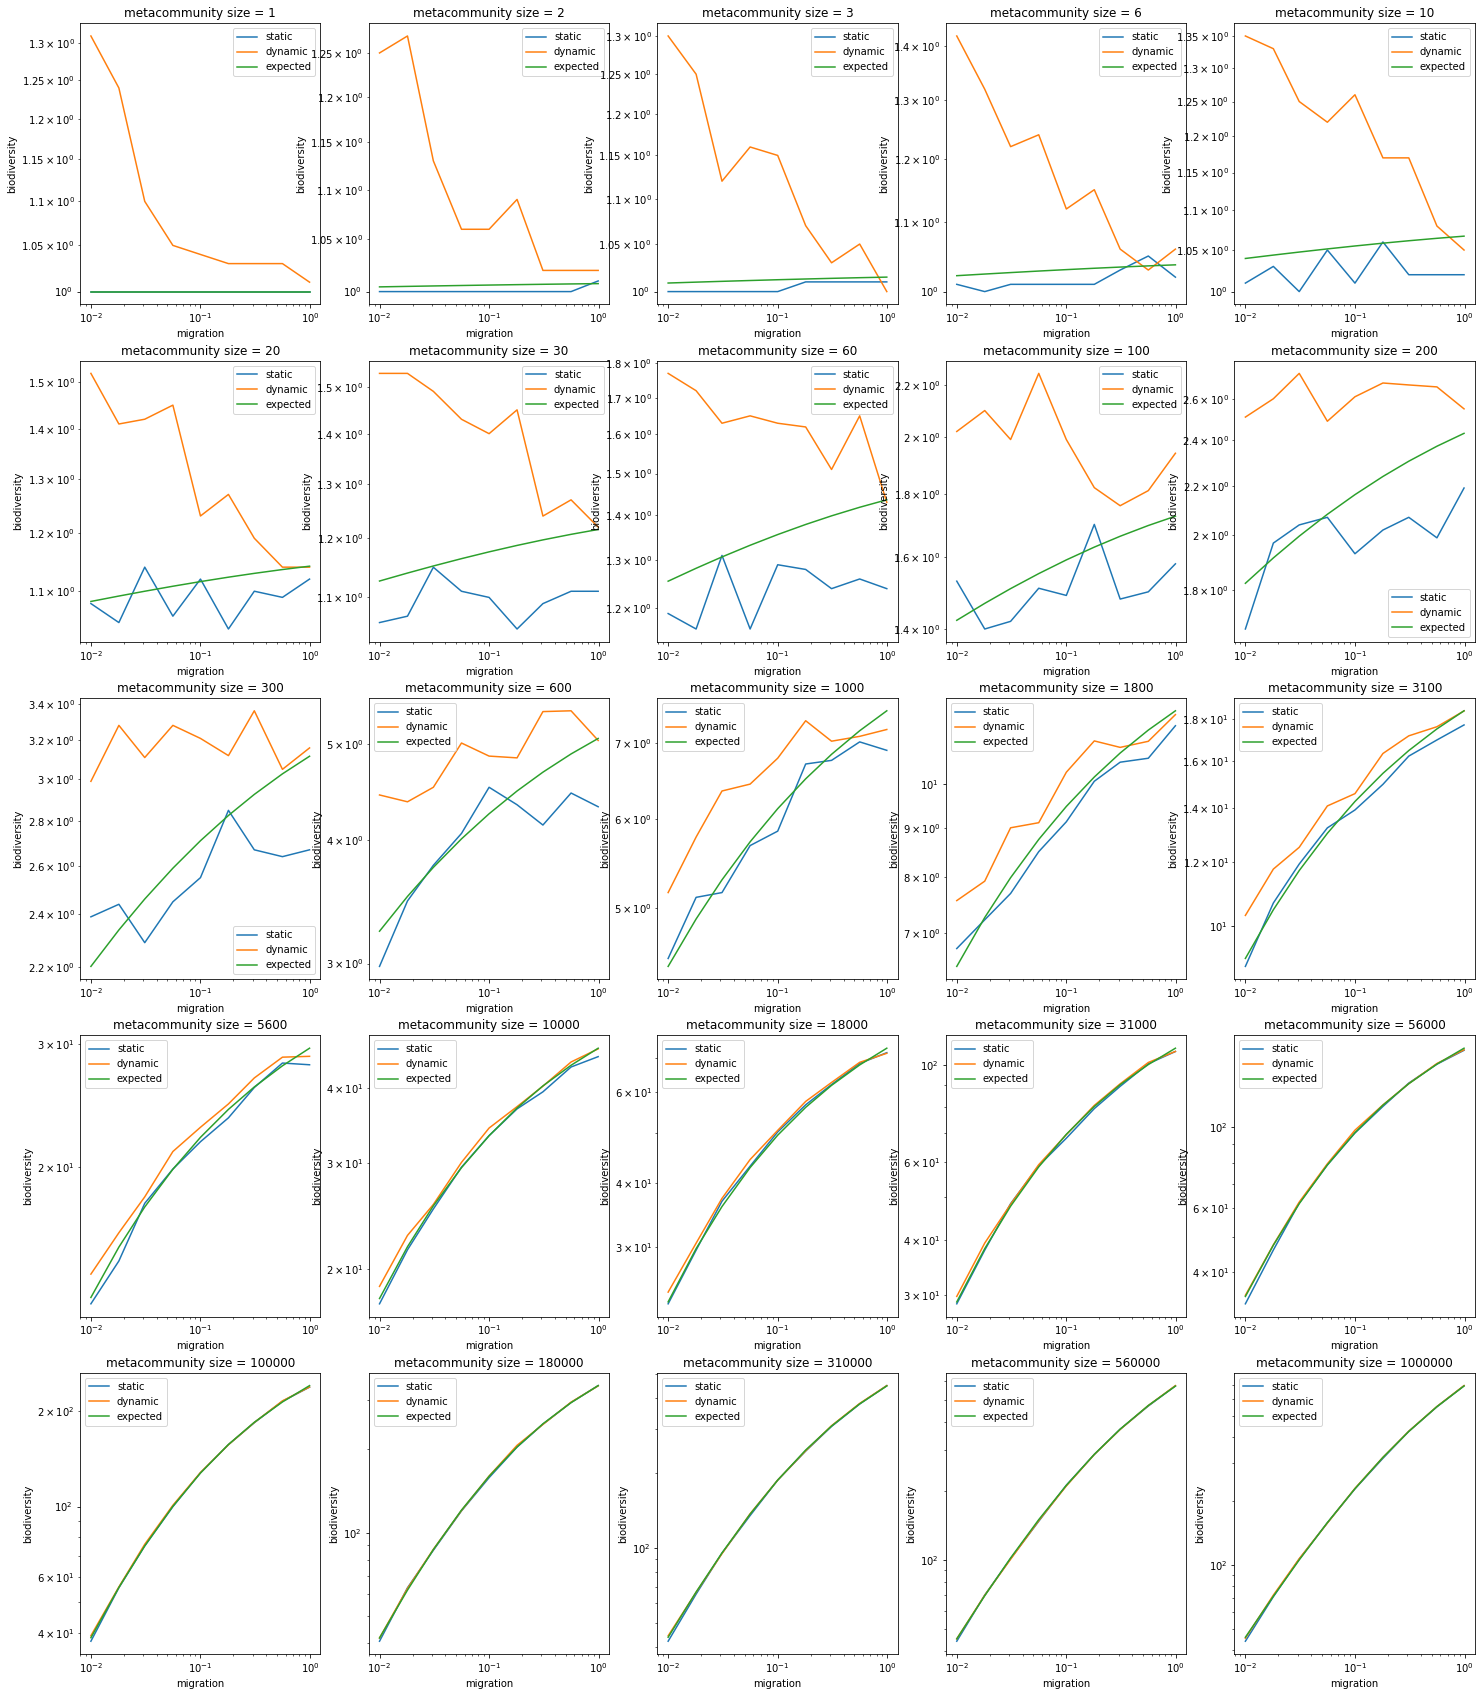

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(25, 30))

for i in range(25):
    ax = axes[i // 5][i % 5]
    
    ax.set_title(f"metacommunity size = {Metas[i]}")
    ax.set_xlabel('migration')
    ax.set_ylabel('biodiversity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(Migrations[i::25], Static[i::25], label='static')
    ax.plot(Migrations[i::25], Dynamic[i::25], label='dynamic')
    ax.plot(Migrations[i::25], Expected[i::25], label='expected')
    ax.legend()

plt.show()